In [3]:
import sys
sys.path.insert(0,  "../../" )
import chimes as chm

# Basic everyday packages
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import numpy as np
import plotly
import copy

# Improving display of tables
from IPython.display import display,HTML,Markdown
from IPython.display import IFrame
from itables import init_notebook_mode,options
options.columnDefs = [{"className": "dt-left", "targets": "_all"}]
options.classes="display nowrap compact"
options.scrollY="400px"
options.scrollCollapse=True
options.paging=False
pd.set_option('display.max_colwidth', None)
pd.set_option("display.colheader_justify","left")

# Interactive matplotlib figures, use plt.close('all') when too many are open
init_notebook_mode(all_interactive=True)
%matplotlib widget

## Tomas Mazak's workaround for Latex plotly rendering
import plotly.graph_objs as go
from IPython.display import display, HTML
plotly.offline.init_notebook_mode()
display(HTML('<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'))


<IPython.core.display.Javascript object>

In [4]:

def lognormal( std_dev=.1,mean=1, size=1):
    # Calculate mu and sigma for the underlying normal distribution
    mu = np.log(mean**2 / np.sqrt(std_dev**2 + mean**2))
    sigma = np.sqrt(np.log(1 + (std_dev**2 / mean**2)))
    
    # Generate samples from the lognormal distribution
    samples = np.random.lognormal(mu, sigma, size)
    
    return samples


## RUN WITH ONLY WAGE LINKAGE BETWEEN SECTORS

In [5]:
hub=chm.Hub('E-CHIMES2')
N=3
Noise = 0.5

### CREATING RANDOM PARAMETERS 
eigenvalues= -1
while np.min(eigenvalues)<0:
    d0={}
    #Internal sector coefficients 
    d0['za']=lognormal(Noise,size=N)
    d0['zw']=lognormal(Noise,size=N)
    d0['nu']=3*lognormal(Noise,size=N)
    d0['delta']=0.03*lognormal(Noise,size=N)

    # Sector coupling coefficients     
    d0['Gamma']=np.diag(lognormal(Noise,size=N)/10)
    d0['Xi']=np.diag(lognormal(Noise,size=N))
    
    d0['kappaC']=lognormal(Noise,size=N)
    d0['kappaC']/=np.sum(d0['kappaC'])
    
    d0['inflation']=0
    dparam0 = hub.supplements['generateNgoodwin'](N,d0) 
    
    Mgrowth = np.identity(N) - dparam0['Gamma'] - np.diag(dparam0['nu'])*np.matmul(dparam0['Xi'],( np.diag(dparam0['delta'])+(dparam0['alpha']+dparam0['n'])*np.ones_like(dparam0['Gamma'])) )
    eigenvalues = np.linalg.eigvals(Mgrowth)

### ADJUSTING PRICE AND CAPITAL TO ENSURE EQUILIBRIUM 
dparam0['p'] = hub.supplements['pForROC'](dparam0) # Price equilibrium
K= hub.supplements['Kfor0dotV'](dparam0) # Scaling of K between sectors

### ADDING NOISE ON CAPITAL: Destabilize wage variation and inventories variation
employment = 2
while employment>1:
    dparam0['K']=K*dparam0['employment']*dparam0['N']/np.sum(K/(dparam0['a'])) # homotetic scaling for employment and N
    dparam0['K']*=lognormal(Noise,size=N)
    employment=np.sum(dparam0['K']/(dparam0['a']))/dparam0['N']
    print(employment)
dparam0['p']*=lognormal(0.05*Noise,size=N)

hub.set_fields(**dparam0,verb=False)
#hub.get_summary()

[0.99482459]


In [7]:
R = hub.get_dfields()
Matrices = ['MtransactI', 'MtransactY']
Vectors = [['pC', 'Consumption', 'Household', True],
           ['wL', 'Wages', 'Household', False],
           ['rD', 'Interests', 'Banks', False]]
Scalars = [['rDh', 'Household', 'Banks', 'Interests', False]]
Nodes,Links = hub.supplements['Generate_LinksNodes_CHIMES'](hub,Matrices,Vectors,Scalars,coloroffset=0)

F= chm._plots.Sankey(title='Monetary flow for E-CHIMES',
                  Nodes=Nodes,
                  Links0=Links,
                  units='$',
                  #value(R,'time')+1, 
                  time=R['time']['value'][:-1, 0, 0, 0, 0])

KeyError: 'Generate_LinksNodes_CHIMES'

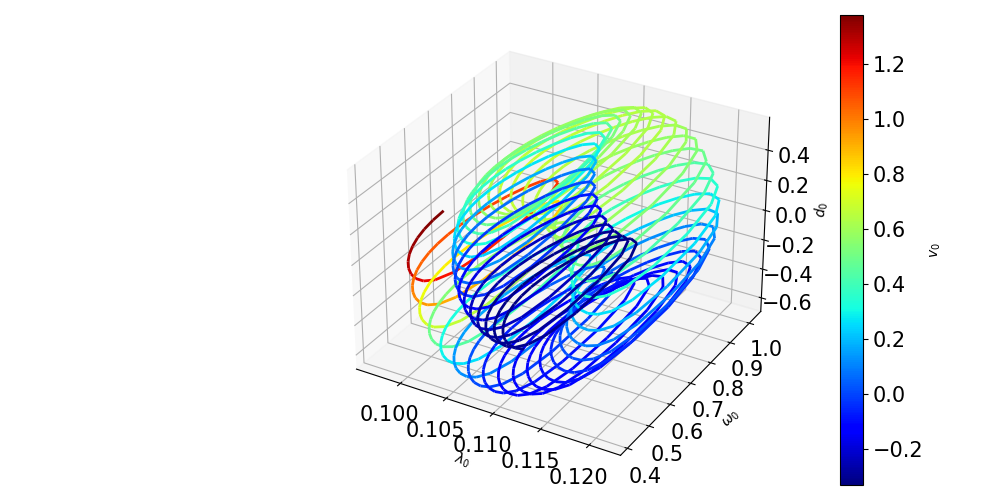

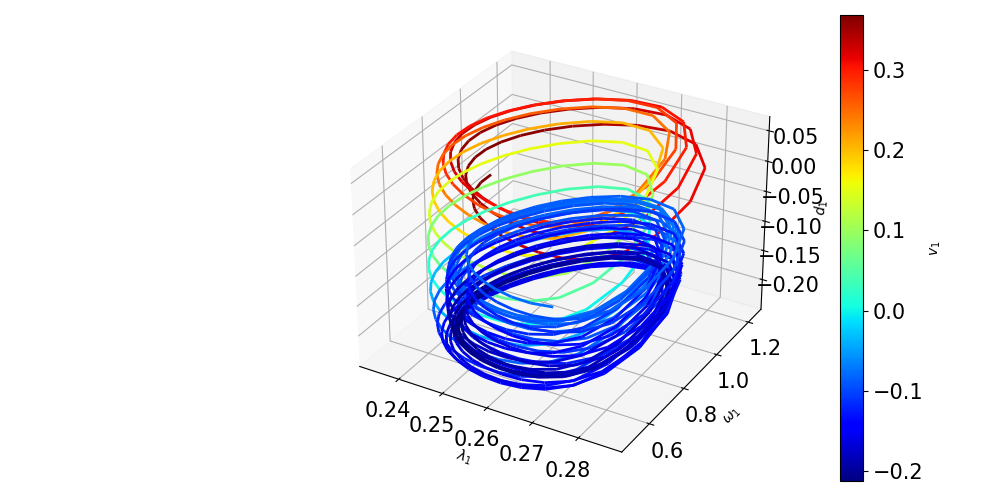

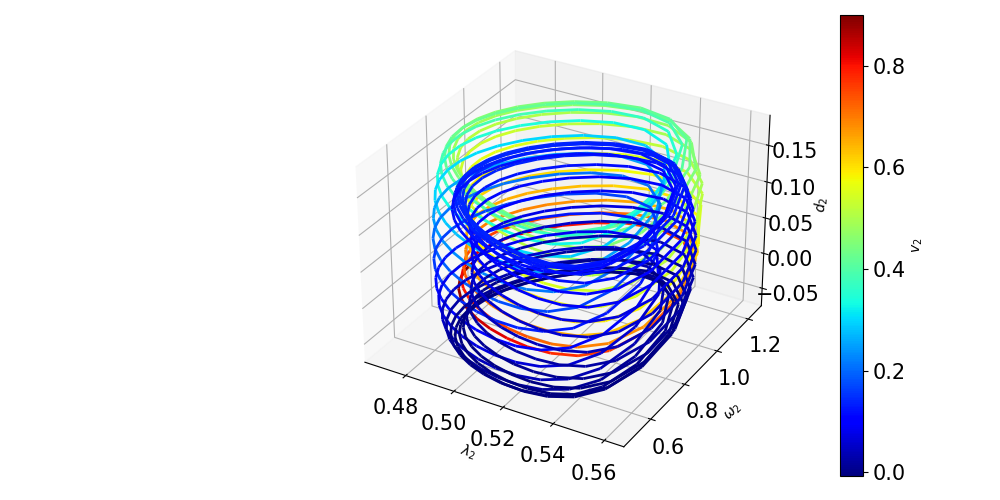

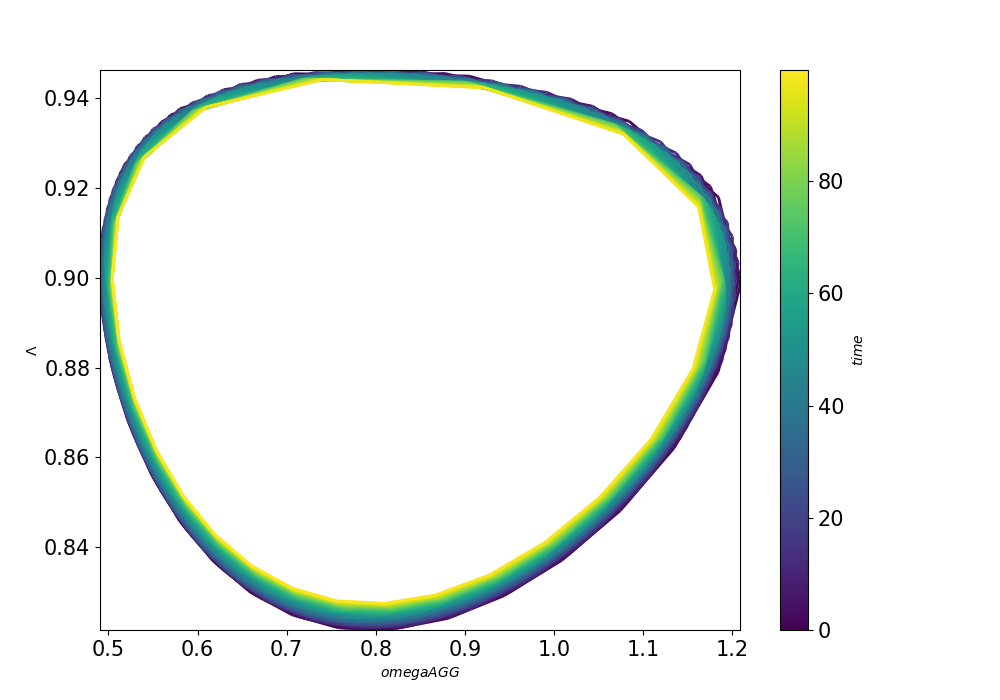

In [5]:
for sect in range(N):
    chm.Plots.XYZ(hub,['employment',str(sect)],['omega',str(sect)],['d',str(sect)],color=['v',str(sect)]) 
chm.Plots.XY(hub,'omegaAGG','employmentAGG')#,'rd',color='time')

## With now coupling matrices

In [8]:
hub=chm.Hub('E-CHIMES2')
N=3
Noise = 0.5

### CREATING RANDOM PARAMETERS 
eigenvalues= -1
while np.min(eigenvalues)<0:
    d0={}
    #Internal sector coefficients 
    d0['za']=lognormal(Noise,size=N)
    d0['zw']=lognormal(Noise,size=N)
    d0['nu']=3*lognormal(Noise,size=N)
    d0['delta']=0.03*lognormal(Noise,size=N)

    # Sector coupling coefficients     
    d0['Gamma']=lognormal(Noise,size=(N,N))/10
    d0['Xi']=lognormal(Noise,size=(N,N))
    
    d0['kappaC']=lognormal(Noise,size=N)
    d0['kappaC']/=np.sum(d0['kappaC'])
    
    d0['inflation']=0
    dparam0 = hub.supplements['generateNgoodwin'](N,d0) 
    
    Mgrowth = np.identity(N) - dparam0['Gamma'] - np.diag(dparam0['nu'])*np.matmul(dparam0['Xi'],( np.diag(dparam0['delta'])+(dparam0['alpha']+dparam0['n'])*np.ones_like(dparam0['Gamma'])) )
    eigenvalues = np.linalg.eigvals(Mgrowth)

### ADJUSTING PRICE AND CAPITAL TO ENSURE EQUILIBRIUM 
dparam0['p'] = hub.supplements['pForROC'](dparam0) # Price equilibrium
K= hub.supplements['Kfor0dotV'](dparam0) # Scaling of K between sectors

### ADDING NOISE ON CAPITAL: Destabilize wage variation and inventories variation
employment = 2
while employment>1:
    dparam0['K']=K*dparam0['employment']*dparam0['N']/np.sum(K/(dparam0['a'])) # homotetic scaling for employment and N
    dparam0['K']*=lognormal(Noise,size=N)
    employment=np.sum(K/(dparam0['a']))/dparam0['N']
    print('Employment',employment)

dparam0['p']*=lognormal(0.05*Noise,size=N)
hub=chm.Hub('E-CHIMES2')
hub.set_fields(**dparam0)
#hub.get_summary()

Employment [0.265188]


c:\ProgramData\Anaconda3\envs\py3.11\Lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



In [17]:
hub=chm.Hub('E-CHIMES2')
hub.set_fields(**dparam0)

time step 2000 / 2000


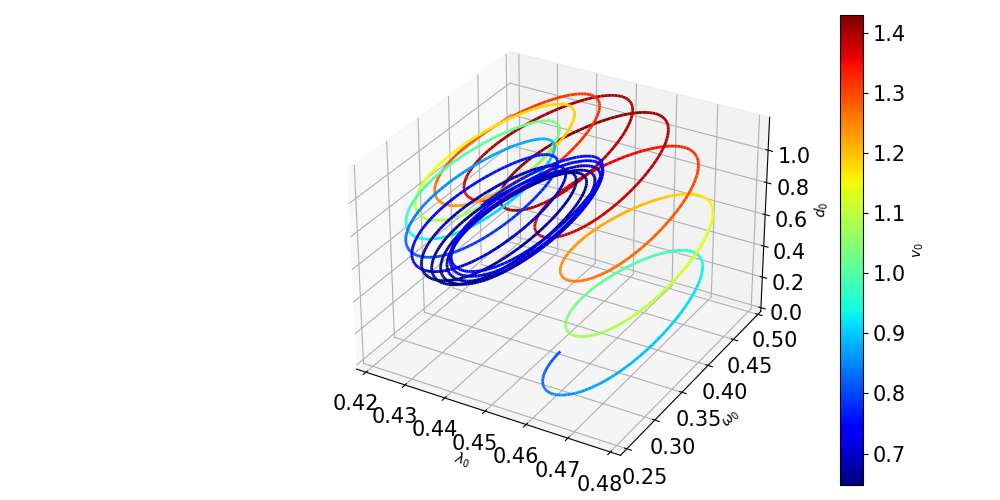

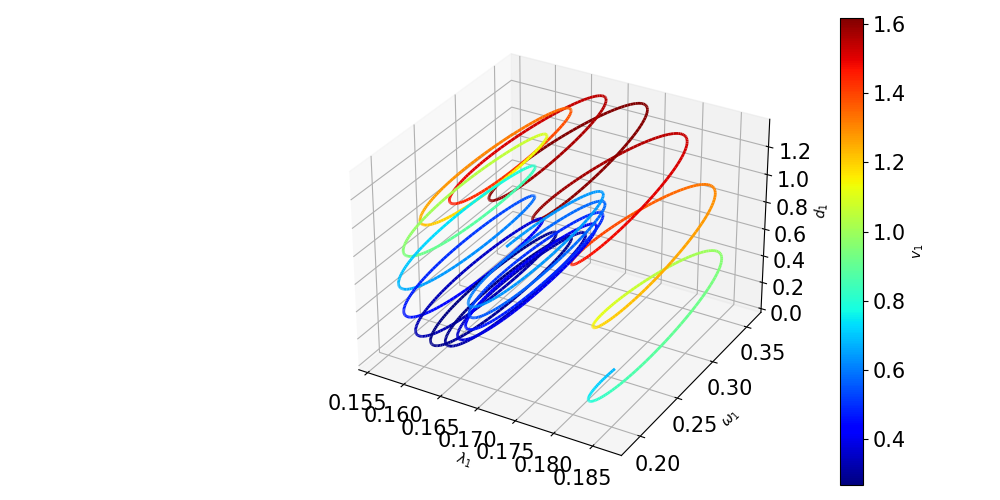

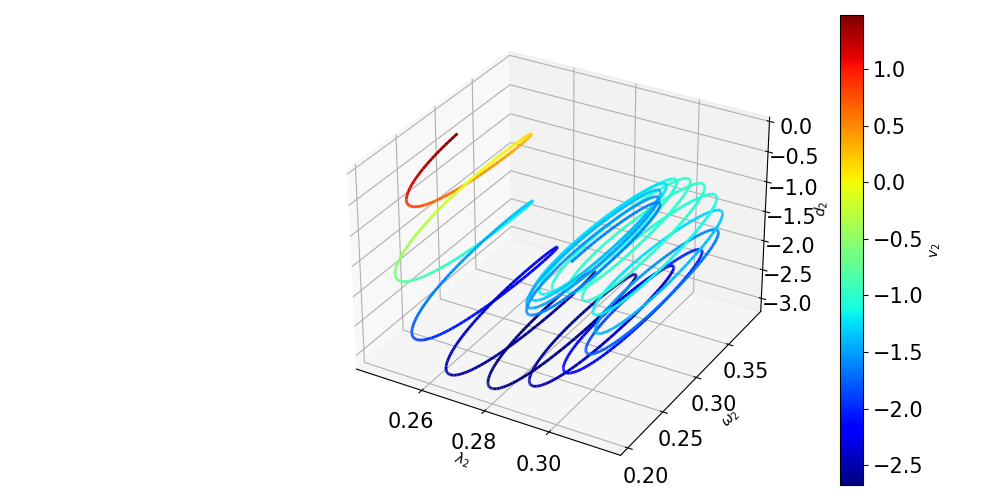

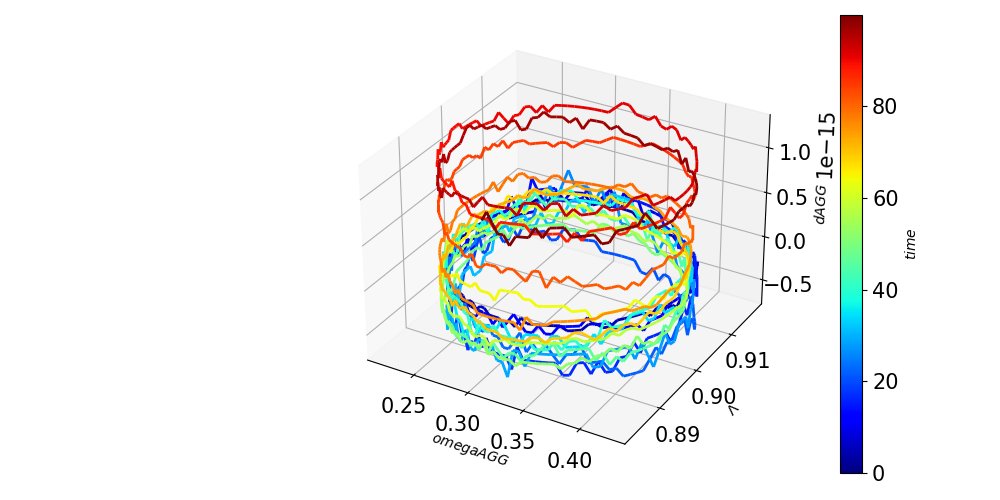

In [18]:
hub.set_fields(dt=0.05,Tsim=100)
hub.run()
#chm.Plots.nyaxis(hub,[['employmentAGG'],['omegaAGG'],['w0']])

#hub.get_summary()

for sect in range(N):
    chm.Plots.XYZ(hub,['employment',str(sect)],['omega',str(sect)],['d',str(sect)],color=['v',str(sect)]) 
    

chm.Plots.XYZ(hub,'omegaAGG','employmentAGG','dAGG',color='time')#,'rd',color='time')

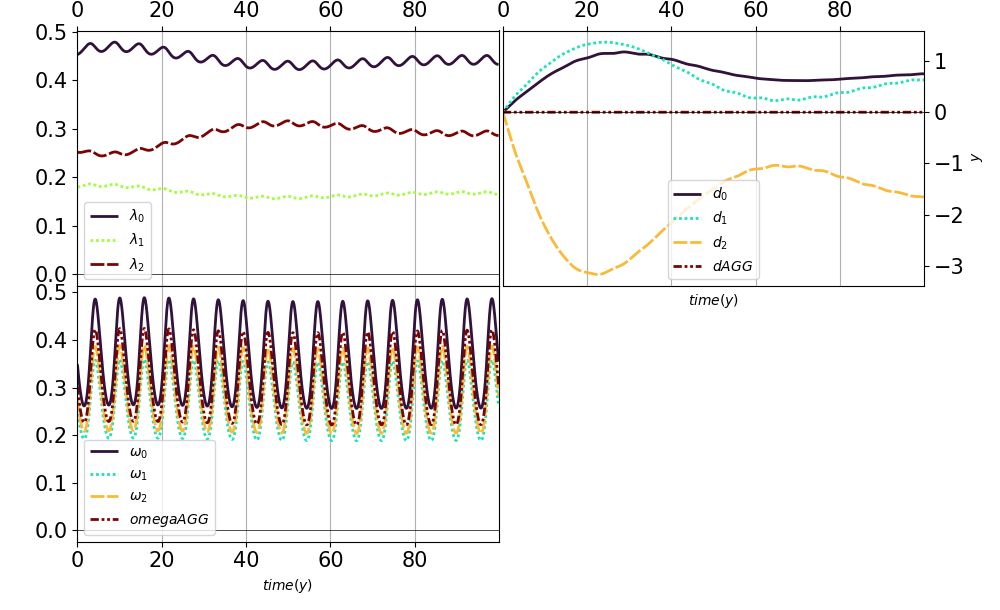

In [21]:

hub.plot(filters_key=['omega','omegaAGG','employment','d','dAGG'],separate_variables={'':['omega','omegaAGG']})


## Specific sector roles

In [187]:
hub=chm.Hub('E-CHIMES2')
N=3
Noise = 0.5

### CREATING RANDOM PARAMETERS 
eigenvalues= -1
while np.min(eigenvalues)<0:
    d0={}
    #Internal sector coefficients 
    d0['za']=lognormal(Noise,size=N)
    d0['zw']=lognormal(Noise,size=N)
    d0['nu']=3*lognormal(Noise,size=N)
    d0['delta']=0.03*lognormal(Noise,size=N)

    # Sector coupling coefficients     
    d0['Gamma'] = [[ 0 , 0.1 , 0],
                   [ 0 , 0.1 , 0],
                   [ 0 , 0.1 , 0]]
    d0['Xi'] =    [[ 0 , 0 , 1],
                   [ 0 , 0 , 1],
                   [ 0 , 0 , 1]]
    #d0['Gamma']=lognormal(Noise,size=(N,N))/10
    d0['Xi']=lognormal(Noise,size=(N,N))
    
    Mgrowth = np.identity(N) - dparam0['Gamma'] - np.diag(dparam0['nu'])*np.matmul(dparam0['Xi'],( np.diag(dparam0['delta'])+(dparam0['alpha']+dparam0['n'])*np.ones_like(dparam0['Gamma'])) )
    eigenvalues = np.linalg.eigvals(Mgrowth)
    
d0['kappaC']=[1,0,0]
    
d0['inflation']=0
dparam0 = hub.supplements['generateNgoodwin'](N,d0) 
    


### ADJUSTING PRICE AND CAPITAL TO ENSURE EQUILIBRIUM 
dparam0['p'] = hub.supplements['pForROC'](dparam0) # Price equilibrium
K= hub.supplements['Kfor0dotV'](dparam0) # Scaling of K between sectors

### ADDING NOISE ON CAPITAL: Destabilize wage variation and inventories variation
employment = 2
while employment>1:
    dparam0['K']=K*dparam0['employment']*dparam0['N']/np.sum(K/(dparam0['a'])) # homotetic scaling for employment and N
    dparam0['K']*=lognormal(Noise,size=N)
    employment=np.sum(K/(dparam0['a']))/dparam0['N']
    print('Employment',employment)

dparam0['p']*=lognormal(0.05*Noise,size=N)

hub.set_fields(**dparam0)
#hub.get_summary()

Employment [-0.10915378]


time step 400 / 400


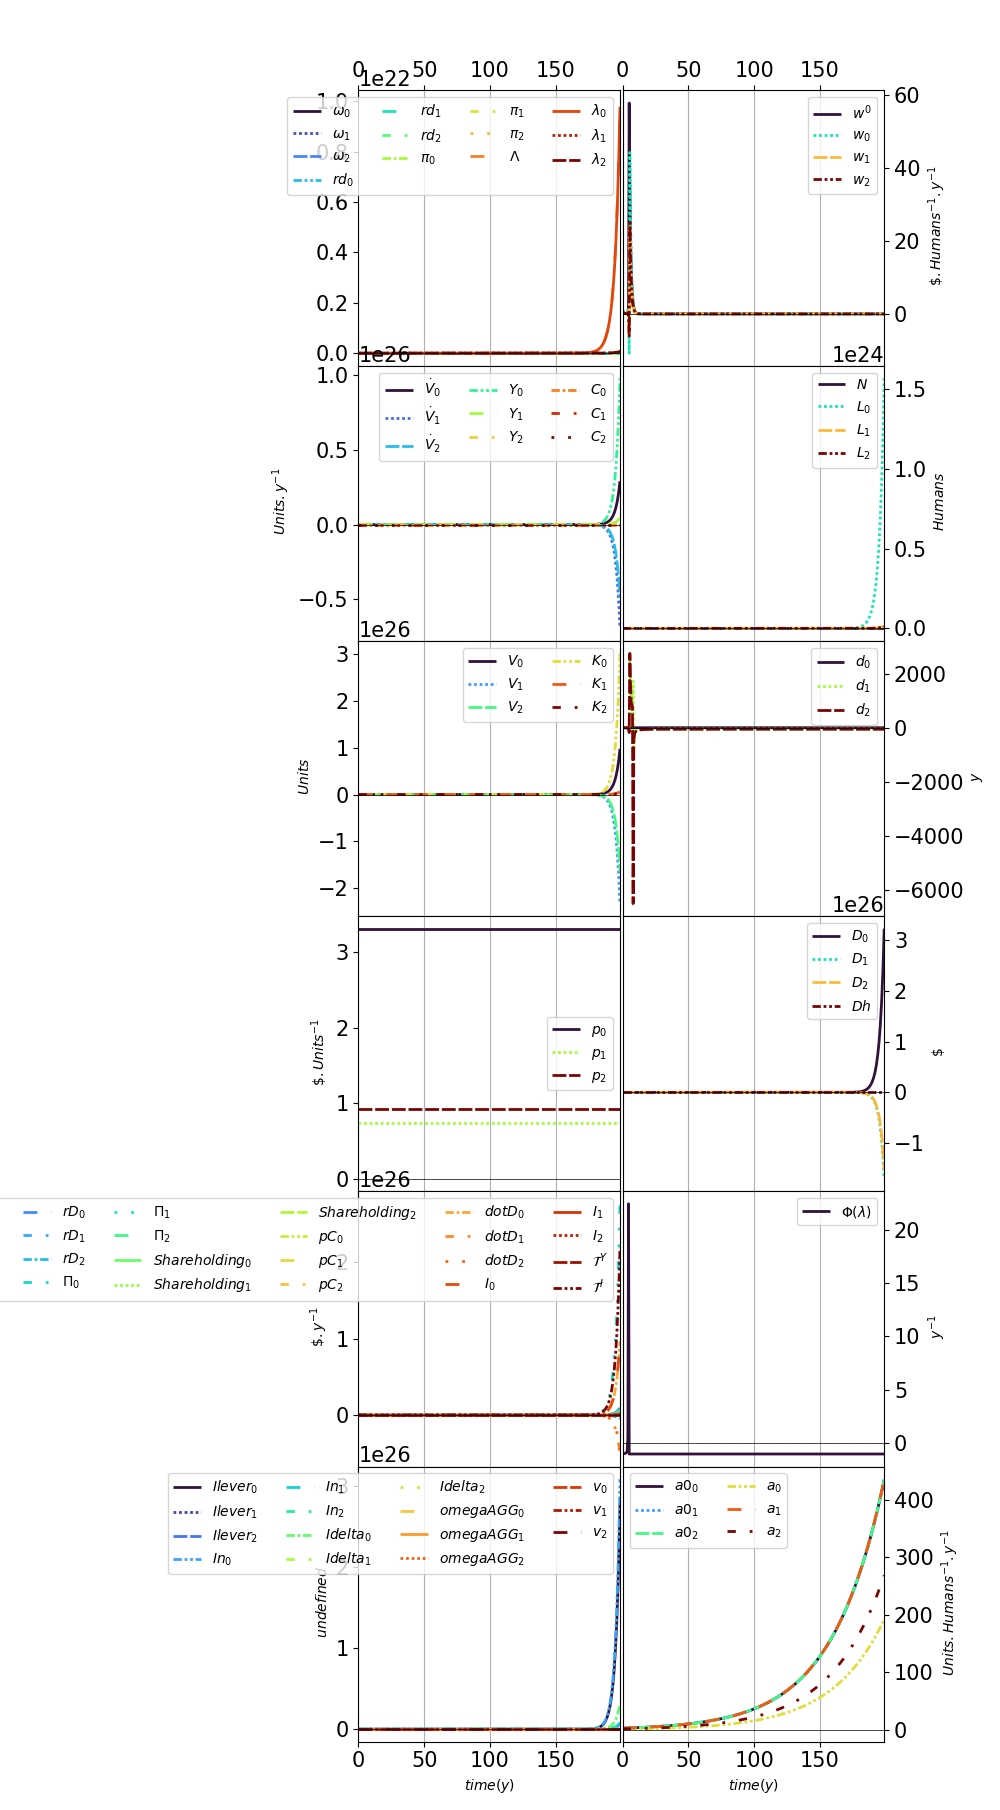

Model       : E-CHIMES2
Economic Core for multisectoral models
File        : c:\Users\Paul Valcke\Documents\GitHub\CHIMES-DaluS\tests\unit\../..\models\ECHIMES\NotIncorporated\_model_E-CHIMES2.py
#################### Fields ####################
statevar        028 ['w', 'a', 'rD', 'Idelta', 'Y', 'rd', 'MtransactY', 'L', 'employment', 'd', 'v', 'wL', 'Pi', 'Shareholding', 'Ilever', 'In', 'I', 'omega', 'pi', 'MtransactI', 'employmentAGG', 'omegaAGG', 'Phillips', 'W', 'C', 'pC', 'dotD', 'dotV']
differential    009 ['D', 'Dh', 'V', 'K', 'p', 'w0', 'a0', 'N', 'time']
parameters      024 ['inflation', 'Delta', 'Nprod', 'za', 'zw', 'ibasket', 'u', 'nu', 'delta', 'Phi0', 'Phi1', 'kappaI', 'kappaC', 'n', 'Mxi', 'r', 'Gamma', 'Mgamma', 'Minter', 'alpha', 'Xi', 'gammai', 'Minvest', 'phinull']
#################### Presets ####################
#################### Flags ####################
run            : [399, 199.5]
cycles         : False
sensitivity    : False
derivative     : False
convergenc

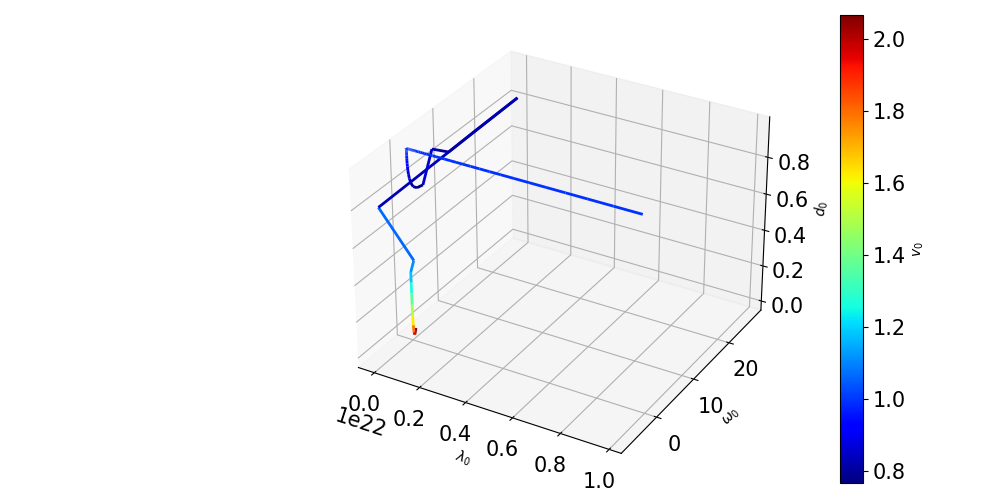

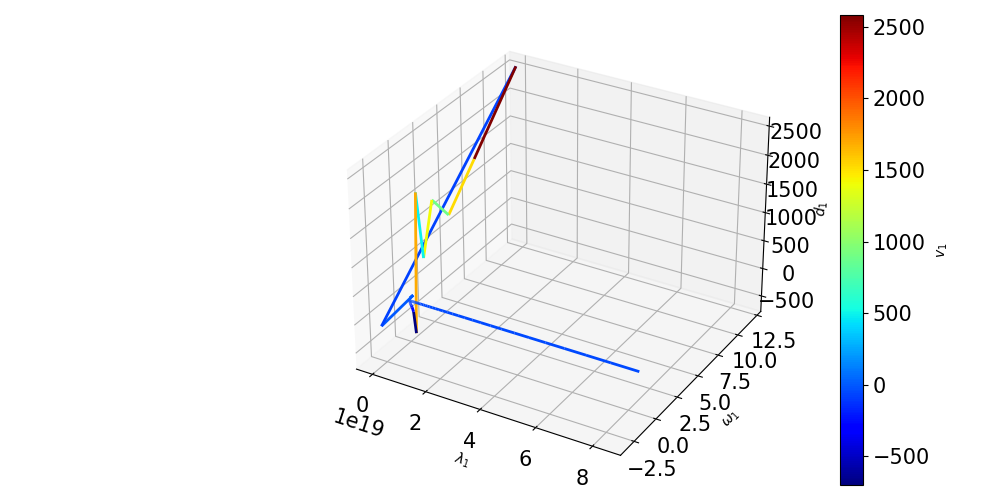

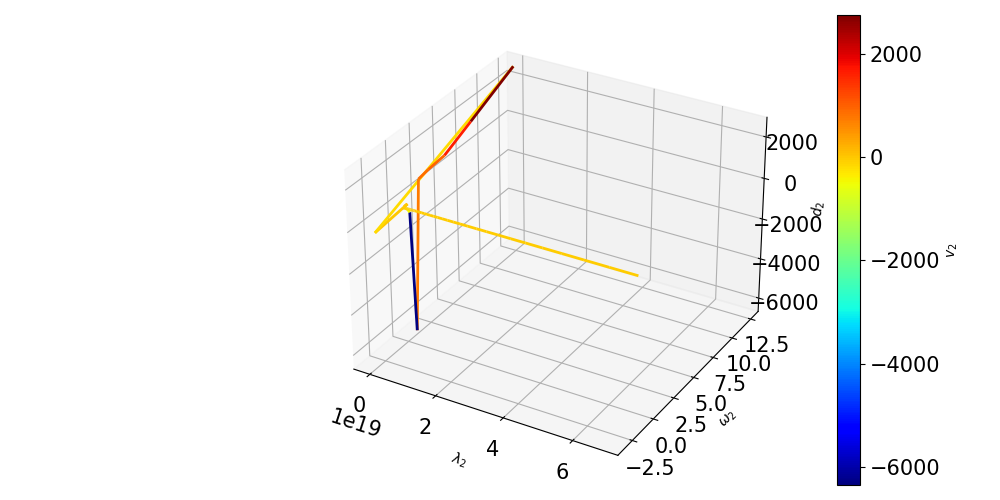

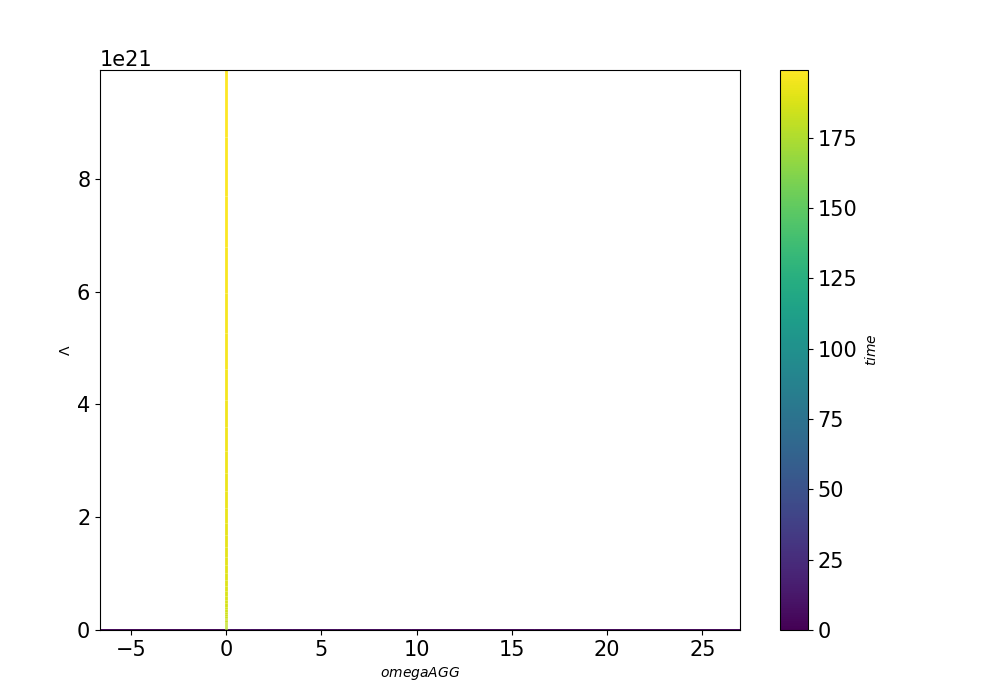

In [188]:
hub.set_fields(dt=0.5,Tsim=          200)
hub.run()
hub.plot()
chm.Plots.nyaxis(hub,[['employmentAGG'],['omegaAGG'],['w0']])

#hub.get_summary()

for sect in range(N):
    chm.Plots.XYZ(hub,['employment',str(sect)],['omega',str(sect)],['d',str(sect)],color=['v',str(sect)]) 
    

chm.Plots.XY(hub,'omegaAGG','employmentAGG',)#,'rd',color='time')